In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import os

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from itertools import product
%matplotlib inline

/Users/floriansestak/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

sample_sub      = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv.gz'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

In [3]:
def lookup(s):
    """ Fast date formating.
        https://stackoverflow.com/questions/29882573/pandas-slow-date-conversion
    """
    dates = {date:pd.to_datetime(date, format='%d.%m.%Y') for date in s.unique()}
    return s.map(dates)

transactions['date'] = lookup(transactions['date'])

# EDA

There are six different data files.

In [4]:
print('transactions:', transactions.shape)
print('items:', items.shape)
print('item_categories:', item_categories.shape)
print('shops:', shops.shape)
print('test:', test.shape)

transactions: (2935849, 6)
items: (22170, 3)
item_categories: (84, 2)
shops: (60, 2)
test: (214200, 3)


## Transactions

This dataset contains the transactions from January 2013 to October 2015. We have to predict the sold items for each shop for November 2015.

In [5]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [7]:
transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [8]:
transactions['shop_id'] = transactions['shop_id'].astype('category')
transactions['item_id'] = transactions['item_id'].astype('category')
transactions['date_block_num'] = transactions['date_block_num'].astype('category')

transactions[['shop_id', 'item_id', 'date_block_num']].describe().T

,count,unique,top,freq
shop_id,2935849,60,31,235636
item_id,2935849,21807,20949,31340
date_block_num,2935849,34,11,143246


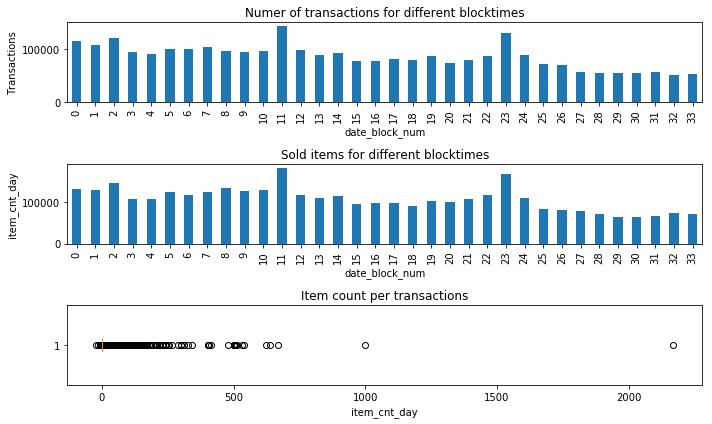

In [9]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
transactions.groupby('date_block_num')['item_cnt_day'].count().plot(kind='bar')
plt.title('Numer of transactions for different blocktimes')
plt.ylabel('Transactions')

plt.subplot(3, 1, 2)
transactions.groupby('date_block_num')['item_cnt_day'].sum().plot(kind='bar')
plt.title('Sold items for different blocktimes')
plt.ylabel('item_cnt_day')

plt.subplot(3, 1, 3)
plt.boxplot(transactions['item_cnt_day'], vert=False)
plt.title('Item count per transactions')
plt.xlabel('item_cnt_day')

plt.tight_layout()
plt.show()

In [10]:
print('Min Item Count:', transactions['item_cnt_day'].min())
print('Max Item Count:', transactions['item_cnt_day'].max())
print('99 Quantile:', transactions['item_cnt_day'].quantile(0.99))

Min Item Count: -22.0
Max Item Count: 2169.0
99 Quantile: 5.0


The most transactions contain only few items, also the 0.99 percentile is 5 so there are few transactions with a huge amount of items maybe there are wrong or there they are real orders. We should measure model performance with and without the huge outliers. It seems that the negative values are returns.

We can also see that in dateblock <u>11</u> and <u>23</u> are much more items sold than during the other dateblock, this is due the fact that these two dateblocks are the month December 2013 and December 2014 and that sounds logical.

## Items

In [11]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [13]:
items['item_category_id'] = items['item_category_id'].astype('category')
items[['item_category_id']].describe().T

,count,unique,top,freq
item_category_id,22170,84,40,5035


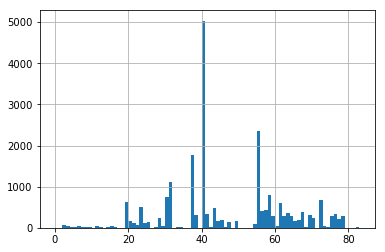

In [14]:
items['item_category_id'].hist(bins=83)
plt.show()

We can clearly see that some categories occur very often, the top category is 40.

## Item Categories

This dataset contains the names for the different item categories.

In [15]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


There are 84 different item categories.

## Shops

This dataset cotains the names for the different shops.

In [17]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [18]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


There are 60 different shops.

## Test

This is the testdata, we need to forecast the sold items for November 2015.

In [19]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [21]:
test['shop_id'] = test['shop_id'].astype('category')
test['item_id'] = test['item_id'].astype('category')

test[['shop_id', 'item_id']].describe().T

,count,unique,top,freq
shop_id,214200,42,59,5100
item_id,214200,5100,22167,42


In the test set we only have to predict sales only for 42 different shops and 5100 different items.

# Aggregate data

We need to aggragate the data, because our data is on daily basis but we want to predict the sales for an entire month.

In [22]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [23]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions[transactions['date_block_num']==block_num]['shop_id'].unique()
    cur_items = transactions[transactions['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = transactions.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
##join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
##sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
## reset index
all_data = all_data.reset_index(drop=True)

/Users/floriansestak/anaconda/envs/tensorflow/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [24]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null category
dtypes: category(1), int64(1), object(1)
memory usage: 371.3+ KB


In [25]:
# Merge with item categories
items['item_category_id'] = items['item_category_id'].astype('int')
all_data = pd.merge(all_data, items[['item_category_id', 'item_id']], on='item_id', how='left')

In [26]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


Now our <u>all_data</u> dataset contains the monthly sales for each item and shop.

In [27]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_category_id
0,0,19,0,0.0,40
1,0,27,0,0.0,19
2,0,28,0,0.0,30
3,0,29,0,0.0,23
4,0,32,0,6.0,40


In [28]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 0 to 10913849
Data columns (total 5 columns):
shop_id             int64
item_id             int64
date_block_num      int64
target              float64
item_category_id    int64
dtypes: float64(1), int64(4)
memory usage: 499.6 MB


In [29]:
all_data['shop_id'] = all_data['shop_id'].astype('category')
all_data['item_id'] = all_data['item_id'].astype('category')
all_data['date_block_num'] = all_data['date_block_num'].astype('category')

all_data[['shop_id', 'item_id', 'date_block_num']].describe().T

,count,unique,top,freq
shop_id,10913850,60,59,233912
item_id,10913850,21807,10340,1586
date_block_num,10913850,34,5,389988


In [30]:
all_data['target'].describe()

count    1.091385e+07
mean     3.342731e-01
std      3.417243e+00
min     -2.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.253000e+03
Name: target, dtype: float64

We can see the huge amount of zero values, this is due the fact that we don't have item sales for all combinations of item, shop and block.

# Feature Engineering

## Mean Encode

In [31]:
# Items
item_id_target_mean = all_data.groupby('item_id')['target'].mean()
all_data['item_target_enc'] = all_data['item_id'].map(item_id_target_mean)

# Item Categories
item_category_target_mean = all_data.groupby('item_category_id')['target'].mean()
all_data['item_cat_target_enc'] = all_data['item_category_id'].map(item_category_target_mean)

# Shops
shop_id_target_mean = all_data.groupby('shop_id')['target'].mean()
all_data['shop_target_enc'] = all_data['shop_id'].map(shop_id_target_mean)

# Leaderboard Probing

## Week2 predict from October 

In [32]:
#oct_2015 = all_data[all_data['date_block_num'] == all_data['date_block_num'].max()]
#predictions = pd.merge(test, oct_2015, on=['shop_id', 'item_id'], how='left')
#predictions['item_cnt_month'].fillna(0, inplace=True)
#predictions.drop(['shop_id', 'item_id', 'date_block_num'], axis=1, inplace=True)
#predictions['item_cnt_month'] = predictions['item_cnt_month'].clip(0, 20)
#predictions.to_csv('submission.csv', index=False)

# Models

In [33]:
X = all_data.drop(['target'], axis=1).copy()
y = all_data['target'].copy()
y[y < 0] = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Ridge Regression

In [ ]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

print('Test error:', np.sqrt(mean_squared_error(y_train, clf.predict(X_train))))
print('Train error:', np.sqrt(mean_squared_error(y_test, clf.predict(X_test))))

## Linear Regression

In [ ]:
clf = LinearRegression()
clf.fit(X_train, y_train)

print('Test error:', np.sqrt(mean_squared_error(y_train, clf.predict(X_train))))
print('Train error:', np.sqrt(mean_squared_error(y_test, clf.predict(X_test))))

## XGBoost

In [41]:
dtrain = xgb.DMatrix(X_train.values, y_train.values)
dtest = xgb.DMatrix(X_test.values, y_test.values)

param = {'silent':1, 
         'objective':'reg:linear', 
         'eval_metric':'rmse',
         'colsample_bytree':0.7,
         'subsample':0.7,
         'min_child_weight':50,
         'max_depth':5,
         'eta':0.1}

watchlist = [(dtest, 'eval'), (dtrain, 'train')]
model = xgb.train(param, dtrain, 1000, watchlist, maximize=False, early_stopping_rounds=50)

[0]	eval-rmse:3.42703	train-rmse:3.26874
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 50 rounds.
[1]	eval-rmse:3.33545	train-rmse:3.18228
[2]	eval-rmse:3.26878	train-rmse:3.11968
[3]	eval-rmse:3.20067	train-rmse:3.0561
[4]	eval-rmse:3.15386	train-rmse:3.01363
[5]	eval-rmse:3.09883	train-rmse:2.96089
[6]	eval-rmse:3.02546	train-rmse:2.8914
[7]	eval-rmse:3.02367	train-rmse:2.88961
[8]	eval-rmse:2.98689	train-rmse:2.85646
[9]	eval-rmse:2.9593	train-rmse:2.83052
[10]	eval-rmse:2.9136	train-rmse:2.78621
[11]	eval-rmse:2.8893	train-rmse:2.76425
[12]	eval-rmse:2.88803	train-rmse:2.76294
[13]	eval-rmse:2.86572	train-rmse:2.74345
[14]	eval-rmse:2.85253	train-rmse:2.73212
[15]	eval-rmse:2.85154	train-rmse:2.73107
[16]	eval-rmse:2.85025	train-rmse:2.72978
[17]	eval-rmse:2.83468	train-rmse:2.71474
[18]	eval-rmse:2.82061	train-rmse:2.70276
[19]	eval-rmse:2.81979	train-rmse:2.70195
[20]	eval-rmse:2.80803	train-r

[191]	eval-rmse:2.4941	train-rmse:2.389
[192]	eval-rmse:2.49361	train-rmse:2.38884
[193]	eval-rmse:2.49243	train-rmse:2.38801
[194]	eval-rmse:2.49141	train-rmse:2.38693
[195]	eval-rmse:2.49059	train-rmse:2.38667
[196]	eval-rmse:2.48955	train-rmse:2.38584
[197]	eval-rmse:2.48951	train-rmse:2.38587
[198]	eval-rmse:2.48959	train-rmse:2.38574
[199]	eval-rmse:2.48795	train-rmse:2.3847
[200]	eval-rmse:2.48793	train-rmse:2.38468
[201]	eval-rmse:2.48781	train-rmse:2.38423
[202]	eval-rmse:2.48747	train-rmse:2.38393
[203]	eval-rmse:2.48676	train-rmse:2.38365
[204]	eval-rmse:2.48656	train-rmse:2.3831
[205]	eval-rmse:2.48633	train-rmse:2.38239
[206]	eval-rmse:2.48578	train-rmse:2.38224
[207]	eval-rmse:2.48519	train-rmse:2.38137
[208]	eval-rmse:2.48458	train-rmse:2.38117
[209]	eval-rmse:2.48332	train-rmse:2.3797
[210]	eval-rmse:2.48204	train-rmse:2.37868
[211]	eval-rmse:2.48157	train-rmse:2.3781
[212]	eval-rmse:2.48123	train-rmse:2.37766
[213]	eval-rmse:2.48109	train-rmse:2.37754
[214]	eval-rmse:2.

[383]	eval-rmse:2.42284	train-rmse:2.31782
[384]	eval-rmse:2.42268	train-rmse:2.31762
[385]	eval-rmse:2.42266	train-rmse:2.31755
[386]	eval-rmse:2.42263	train-rmse:2.31748
[387]	eval-rmse:2.42247	train-rmse:2.3166
[388]	eval-rmse:2.42206	train-rmse:2.31638
[389]	eval-rmse:2.4214	train-rmse:2.31544
[390]	eval-rmse:2.42114	train-rmse:2.31543
[391]	eval-rmse:2.42142	train-rmse:2.3153
[392]	eval-rmse:2.42108	train-rmse:2.3152
[393]	eval-rmse:2.42069	train-rmse:2.31491
[394]	eval-rmse:2.41983	train-rmse:2.31398
[395]	eval-rmse:2.4194	train-rmse:2.31394
[396]	eval-rmse:2.41942	train-rmse:2.31363
[397]	eval-rmse:2.41931	train-rmse:2.31347
[398]	eval-rmse:2.41891	train-rmse:2.3131
[399]	eval-rmse:2.41846	train-rmse:2.31303
[400]	eval-rmse:2.41839	train-rmse:2.31283
[401]	eval-rmse:2.41835	train-rmse:2.31243
[402]	eval-rmse:2.41878	train-rmse:2.31213
[403]	eval-rmse:2.41827	train-rmse:2.31167
[404]	eval-rmse:2.41811	train-rmse:2.31143
[405]	eval-rmse:2.41768	train-rmse:2.31099
[406]	eval-rmse:2

[575]	eval-rmse:2.3891	train-rmse:2.27746
[576]	eval-rmse:2.38872	train-rmse:2.27725
[577]	eval-rmse:2.38846	train-rmse:2.27683
[578]	eval-rmse:2.38832	train-rmse:2.27673
[579]	eval-rmse:2.38806	train-rmse:2.27645
[580]	eval-rmse:2.38776	train-rmse:2.27618
[581]	eval-rmse:2.38776	train-rmse:2.27618
[582]	eval-rmse:2.38772	train-rmse:2.27611
[583]	eval-rmse:2.38771	train-rmse:2.27607
[584]	eval-rmse:2.38781	train-rmse:2.27604
[585]	eval-rmse:2.38721	train-rmse:2.27595
[586]	eval-rmse:2.38703	train-rmse:2.2758
[587]	eval-rmse:2.38714	train-rmse:2.27577
[588]	eval-rmse:2.3865	train-rmse:2.27541
[589]	eval-rmse:2.38631	train-rmse:2.27538
[590]	eval-rmse:2.3863	train-rmse:2.27527
[591]	eval-rmse:2.38631	train-rmse:2.27512
[592]	eval-rmse:2.3865	train-rmse:2.27504
[593]	eval-rmse:2.38546	train-rmse:2.27412
[594]	eval-rmse:2.38494	train-rmse:2.27386
[595]	eval-rmse:2.38457	train-rmse:2.27374
[596]	eval-rmse:2.38446	train-rmse:2.27372
[597]	eval-rmse:2.38415	train-rmse:2.27341
[598]	eval-rmse:

[767]	eval-rmse:2.36522	train-rmse:2.24875
[768]	eval-rmse:2.36539	train-rmse:2.24869
[769]	eval-rmse:2.36546	train-rmse:2.24855
[770]	eval-rmse:2.36545	train-rmse:2.24855
[771]	eval-rmse:2.36631	train-rmse:2.24837
[772]	eval-rmse:2.36577	train-rmse:2.24804
[773]	eval-rmse:2.36567	train-rmse:2.24802
[774]	eval-rmse:2.36558	train-rmse:2.248
[775]	eval-rmse:2.36501	train-rmse:2.24786
[776]	eval-rmse:2.36459	train-rmse:2.24771
[777]	eval-rmse:2.36468	train-rmse:2.24759
[778]	eval-rmse:2.36464	train-rmse:2.24739
[779]	eval-rmse:2.36441	train-rmse:2.24731
[780]	eval-rmse:2.36457	train-rmse:2.24716
[781]	eval-rmse:2.3643	train-rmse:2.24708
[782]	eval-rmse:2.36452	train-rmse:2.24706
[783]	eval-rmse:2.36438	train-rmse:2.24686
[784]	eval-rmse:2.36429	train-rmse:2.24676
[785]	eval-rmse:2.36412	train-rmse:2.24674
[786]	eval-rmse:2.364	train-rmse:2.24673
[787]	eval-rmse:2.36386	train-rmse:2.24667
[788]	eval-rmse:2.36413	train-rmse:2.24652
[789]	eval-rmse:2.36436	train-rmse:2.24598
[790]	eval-rmse:

[959]	eval-rmse:2.34884	train-rmse:2.22879
[960]	eval-rmse:2.3486	train-rmse:2.22862
[961]	eval-rmse:2.3483	train-rmse:2.22856
[962]	eval-rmse:2.34844	train-rmse:2.22853
[963]	eval-rmse:2.34847	train-rmse:2.22838
[964]	eval-rmse:2.34856	train-rmse:2.22804
[965]	eval-rmse:2.3486	train-rmse:2.2279
[966]	eval-rmse:2.3485	train-rmse:2.22782
[967]	eval-rmse:2.34795	train-rmse:2.22727
[968]	eval-rmse:2.34777	train-rmse:2.22709
[969]	eval-rmse:2.3477	train-rmse:2.22708
[970]	eval-rmse:2.34749	train-rmse:2.22687
[971]	eval-rmse:2.34754	train-rmse:2.22675
[972]	eval-rmse:2.34748	train-rmse:2.22667
[973]	eval-rmse:2.34728	train-rmse:2.22662
[974]	eval-rmse:2.34727	train-rmse:2.2266
[975]	eval-rmse:2.34716	train-rmse:2.22645
[976]	eval-rmse:2.3468	train-rmse:2.2264
[977]	eval-rmse:2.34656	train-rmse:2.22627
[978]	eval-rmse:2.34615	train-rmse:2.22612
[979]	eval-rmse:2.34626	train-rmse:2.22611
[980]	eval-rmse:2.34665	train-rmse:2.22573
[981]	eval-rmse:2.34687	train-rmse:2.22569
[982]	eval-rmse:2.34

# Training data
Save the training data so we can use it in Xcessiv.

In [42]:
all_data.to_csv(os.path.join(DATA_FOLDER, 'train.csv'), index=False)